# Window Architecture Experiment Results

In [8]:
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.stats.api as sms

from db import conn

In [9]:
%matplotlib inline

In [10]:
sns.set_style("whitegrid")

In [11]:
cursor = conn.cursor()
experiment_rows = [r for r in cursor.execute("""
    select g.name, args, dev_metric, test_metric from experiments e
    join experiment_groups g on e.group_id=g.gid
    where g.name=?""", ('mpcnn-v2-window-fix-params-and-seed',))]

In [12]:
len(experiment_rows)

90

In [13]:
experiment_results = {
    'trecqa': [],
    'wikiqa': [],
    'sick': []
}

for row in experiment_rows:
    args = json.loads(row[1])
    dev_metrics = json.loads(row[2])
    test_metrics = json.loads(row[3])
    dataset = args['dataset']
    
    if args['arch'] == 'mpcnn_single_window':
        arch = 'Single Width'
    elif args['arch'] == 'mpcnn_single_window_with_inf':
        arch = 'Single Width/Inf'
    else:
        arch = 'MP-CNN'
    
    res_base = {
        'arch': arch,
        'dataset': dataset,
        'seed': args['seed']
    }
    
    results = []
    
    if dataset in ('trecqa', 'wikiqa'):
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'MAP', 'metric_val': dev_metrics['map']}})
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'MRR', 'metric_val': dev_metrics['mrr']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'MAP', 'metric_val': test_metrics['map']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'MRR', 'metric_val': test_metrics['mrr']}})
    elif dataset == 'sick':
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'pearson', 'metric_val': dev_metrics['pearson']}})
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'spearman', 'metric_val': dev_metrics['spearman']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'pearson', 'metric_val': test_metrics['pearson']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'spearman', 'metric_val': test_metrics['spearman']}})
    
    experiment_results[dataset].extend(results)

In [14]:
trecqa = pd.DataFrame(experiment_results['trecqa'])
wikiqa = pd.DataFrame(experiment_results['wikiqa'])
sick = pd.DataFrame(experiment_results['sick'])

In [15]:
trecqa['arch'].unique()

array(['Single Width', 'MP-CNN', 'Single Width/Inf'], dtype=object)

In [16]:
archs = ['MP-CNN', 'Single Width', 'Single Width/Inf']
def compare_change_to_baseline(df, metric):
    config_ids = df['seed'].unique()
    for arch in archs:
        diffs = []
        for config_id in config_ids:
            baseline = df[(df['seed'] == config_id) & (df['arch'] == 'MP-CNN')].iloc[0]['metric_val']
            conf_perf = df[(df['seed'] == config_id) & (df['arch'] == arch)].iloc[0]['metric_val']
            diffs.append(conf_perf - baseline)

        print(f'Architecture: {arch}')
        print(f'Median of {metric} change compared with single baseline: {np.median(diffs):.4f}')
        print(f'Mean of {metric} change compared with single baseline: {np.mean(diffs):.4f}')

## TrecQA

In [17]:
trec_map_vs_archs_test = trecqa[(trecqa['metric_name'] == 'MAP') & (trecqa['split'] == 'test')]
trec_mrr_vs_archs_test = trecqa[(trecqa['metric_name'] == 'MRR') & (trecqa['split'] == 'test')]
trec_map_vs_archs_dev = trecqa[(trecqa['metric_name'] == 'MAP') & (trecqa['split'] == 'dev')]
trec_mrr_vs_archs_dev = trecqa[(trecqa['metric_name'] == 'MRR') & (trecqa['split'] == 'dev')]

In [18]:
for arch in trec_map_vs_archs_test['arch'].unique():
    arr = trec_map_vs_archs_test[trec_map_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

Single Width: (0.7212, 0.7492)
MP-CNN: (0.6956, 0.8115)
Single Width/Inf: (0.6878, 0.7254)


In [19]:
for arch in trec_mrr_vs_archs_test['arch'].unique():
    arr = trec_mrr_vs_archs_test[trec_mrr_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

Single Width: (0.7596, 0.8199)
MP-CNN: (0.6860, 0.8473)
Single Width/Inf: (0.6824, 0.8270)


In [20]:
trec_map_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
MP-CNN,0.75355,564062.1
Single Width,0.73517,564062.1
Single Width/Inf,0.70658,564062.1


In [21]:
trec_mrr_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
MP-CNN,0.766689,564062.1
Single Width,0.789731,564062.1
Single Width/Inf,0.754677,564062.1


In [22]:
compare_change_to_baseline(trec_map_vs_archs_test, 'MAP')

Architecture: MP-CNN
Median of MAP change compared with single baseline: 0.0000
Mean of MAP change compared with single baseline: 0.0000
Architecture: Single Width
Median of MAP change compared with single baseline: -0.0383
Mean of MAP change compared with single baseline: -0.0184
Architecture: Single Width/Inf
Median of MAP change compared with single baseline: -0.0605
Mean of MAP change compared with single baseline: -0.0470


In [23]:
compare_change_to_baseline(trec_mrr_vs_archs_test, 'MRR')

Architecture: MP-CNN
Median of MRR change compared with single baseline: 0.0000
Mean of MRR change compared with single baseline: 0.0000
Architecture: Single Width
Median of MRR change compared with single baseline: -0.0012
Mean of MRR change compared with single baseline: 0.0230
Architecture: Single Width/Inf
Median of MRR change compared with single baseline: -0.0306
Mean of MRR change compared with single baseline: -0.0120


## WikiQA

In [24]:
wikiqa_map_vs_archs_test = wikiqa[(wikiqa['metric_name'] == 'MAP') & (wikiqa['split'] == 'test')]
wikiqa_mrr_vs_archs_test = wikiqa[(wikiqa['metric_name'] == 'MRR') & (wikiqa['split'] == 'test')]
wikiqa_map_vs_archs_dev = wikiqa[(wikiqa['metric_name'] == 'MAP') & (wikiqa['split'] == 'dev')]
wikiqa_mrr_vs_archs_dev = wikiqa[(wikiqa['metric_name'] == 'MRR') & (wikiqa['split'] == 'dev')]

In [25]:
for arch in wikiqa_map_vs_archs_test['arch'].unique():
    arr = wikiqa_map_vs_archs_test[wikiqa_map_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

MP-CNN: (0.5355, 0.7264)
Single Width: (0.6646, 0.6787)
Single Width/Inf: (0.6640, 0.6730)


In [26]:
for arch in wikiqa_mrr_vs_archs_test['arch'].unique():
    arr = wikiqa_mrr_vs_archs_test[wikiqa_mrr_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

MP-CNN: (0.5410, 0.7387)
Single Width: (0.5770, 0.7315)
Single Width/Inf: (0.6797, 0.6900)


In [27]:
wikiqa_map_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
MP-CNN,0.63096,564062.1
Single Width,0.67162,564062.1
Single Width/Inf,0.66851,564062.1


In [28]:
wikiqa_mrr_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
MP-CNN,0.639890,564062.1
Single Width,0.654282,564062.1
Single Width/Inf,0.684840,564062.1


In [29]:
compare_change_to_baseline(wikiqa_map_vs_archs_test, 'MAP')

Architecture: MP-CNN
Median of MAP change compared with single baseline: 0.0000
Mean of MAP change compared with single baseline: 0.0000
Architecture: Single Width
Median of MAP change compared with single baseline: -0.0272
Mean of MAP change compared with single baseline: 0.0407
Architecture: Single Width/Inf
Median of MAP change compared with single baseline: -0.0345
Mean of MAP change compared with single baseline: 0.0376


In [30]:
compare_change_to_baseline(wikiqa_mrr_vs_archs_test, 'MRR')

Architecture: MP-CNN
Median of MRR change compared with single baseline: 0.0000
Mean of MRR change compared with single baseline: 0.0000
Architecture: Single Width
Median of MRR change compared with single baseline: -0.0215
Mean of MRR change compared with single baseline: 0.0144
Architecture: Single Width/Inf
Median of MRR change compared with single baseline: -0.0283
Mean of MRR change compared with single baseline: 0.0449


/u3/z3tu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/u3/z3tu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


(array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Text yticklabel objects>)

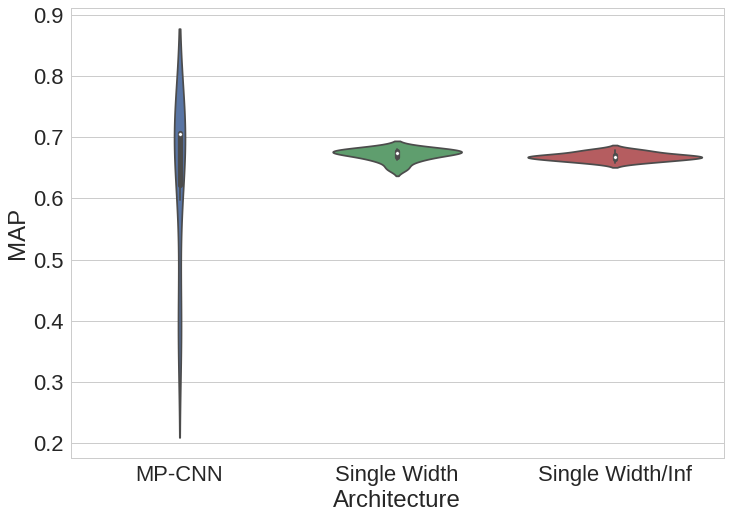

In [31]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.violinplot(x='arch', y='metric_val', data=wikiqa_map_vs_archs_test, order=archs, ax=ax)
plt.xlabel('Architecture', fontsize=24)
plt.ylabel('MAP', fontsize=24)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
# plt.ylim(0.6, 0.75)

## SICK

In [32]:
sick_pearson_vs_archs_test = sick[(sick['metric_name'] == 'pearson') & (sick['split'] == 'test')]
sick_spearman_vs_archs_test = sick[(sick['metric_name'] == 'spearman') & (sick['split'] == 'test')]
sick_pearson_vs_archs_dev = sick[(sick['metric_name'] == 'pearson') & (sick['split'] == 'dev')]
sick_spearman_vs_archs_dev = sick[(sick['metric_name'] == 'spearman') & (sick['split'] == 'dev')]

In [33]:
for arch in sick_pearson_vs_archs_test['arch'].unique():
    arr = sick_pearson_vs_archs_test[sick_pearson_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

Single Width: (0.8358, 0.8419)
Single Width/Inf: (0.8366, 0.8413)
MP-CNN: (0.7843, 0.9005)


In [34]:
for arch in sick_spearman_vs_archs_test['arch'].unique():
    arr = sick_spearman_vs_archs_test[sick_spearman_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

Single Width: (0.7740, 0.7788)
Single Width/Inf: (0.7766, 0.7820)
MP-CNN: (0.7653, 0.8230)


In [35]:
sick_pearson_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
MP-CNN,0.842427,564062.1
Single Width,0.838834,564062.1
Single Width/Inf,0.838925,564062.1


In [36]:
sick_spearman_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
MP-CNN,0.794169,564062.1
Single Width,0.776369,564062.1
Single Width/Inf,0.779302,564062.1


In [37]:
compare_change_to_baseline(sick_pearson_vs_archs_test, 'pearson')

Architecture: MP-CNN
Median of pearson change compared with single baseline: 0.0000
Mean of pearson change compared with single baseline: 0.0000
Architecture: Single Width
Median of pearson change compared with single baseline: -0.0281
Mean of pearson change compared with single baseline: -0.0036
Architecture: Single Width/Inf
Median of pearson change compared with single baseline: -0.0284
Mean of pearson change compared with single baseline: -0.0035


In [38]:
compare_change_to_baseline(sick_spearman_vs_archs_test, 'spearman')

Architecture: MP-CNN
Median of spearman change compared with single baseline: 0.0000
Mean of spearman change compared with single baseline: 0.0000
Architecture: Single Width
Median of spearman change compared with single baseline: -0.0312
Mean of spearman change compared with single baseline: -0.0178
Architecture: Single Width/Inf
Median of spearman change compared with single baseline: -0.0241
Mean of spearman change compared with single baseline: -0.0149


/u3/z3tu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/u3/z3tu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


(array([ 0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 7 Text yticklabel objects>)

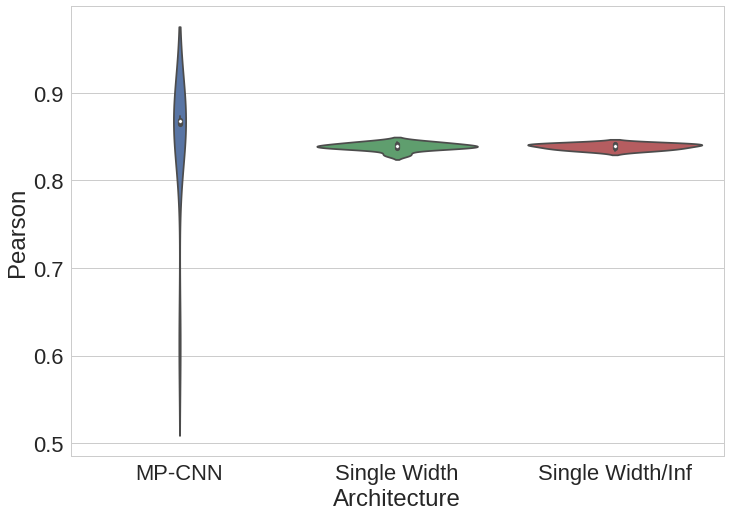

In [39]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.violinplot(x='arch', y='metric_val', data=sick_pearson_vs_archs_test, order=archs, ax=ax)
plt.xlabel('Architecture', fontsize=24)
plt.ylabel('Pearson', fontsize=24)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
# plt.ylim(0.86, 0.88)

/u3/z3tu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/u3/z3tu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


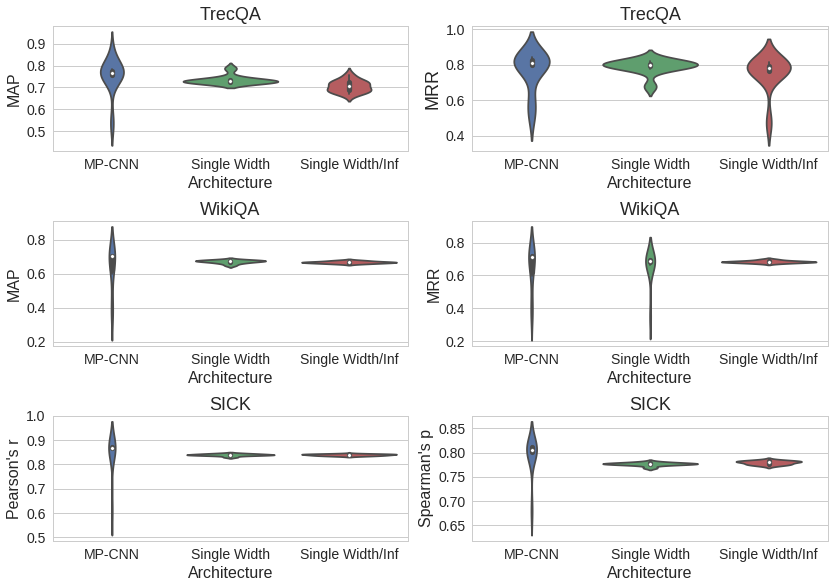

In [40]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
title_size = 18
axis_size = 16
tick_size = 14

ax = plt.subplot(321)
sns.violinplot(x='arch', y='metric_val', data=trec_map_vs_archs_test, order=archs, ax=ax)
plt.ylabel('MAP', fontsize=axis_size)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title('TrecQA', fontsize=title_size)

ax = plt.subplot(322)
sns.violinplot(x='arch', y='metric_val', data=trec_mrr_vs_archs_test, order=archs, ax=ax)
plt.ylabel('MRR', fontsize=18)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title('TrecQA', fontsize=title_size)

ax = plt.subplot(323)
sns.violinplot(x='arch', y='metric_val', data=wikiqa_map_vs_archs_test, order=archs, ax=ax)
plt.ylabel('MAP', fontsize=axis_size)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title('WikiQA', fontsize=title_size)

ax = plt.subplot(324)
sns.violinplot(x='arch', y='metric_val', data=wikiqa_mrr_vs_archs_test, order=archs, ax=ax)
plt.ylabel('MRR', fontsize=axis_size)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title('WikiQA', fontsize=title_size)

ax = plt.subplot(325)
sns.violinplot(x='arch', y='metric_val', data=sick_pearson_vs_archs_test, order=archs, ax=ax)
plt.ylabel("Pearson's r", fontsize=axis_size)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title('SICK', fontsize=title_size)

ax = plt.subplot(326)
sns.violinplot(x='arch', y='metric_val', data=sick_spearman_vs_archs_test, order=archs, ax=ax)
plt.ylabel("Spearman's p", fontsize=axis_size)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title('SICK', fontsize=title_size)
plt.tight_layout()
plt.savefig('window_arch_violin.pdf')